In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=094e58d18b04e8c2357900553e6fab226572e3b20bb94e56cfad1daf294e0a13
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [1]:
import os
import time
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import linalg
# For FID and Inception score
from torchvision.models import inception_v3

In [2]:
# Setup paths and device
dataroot = os.path.join(os.getcwd(), 'data')
os.makedirs(dataroot, exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("generated_images", exist_ok=True)
os.makedirs("evaluation", exist_ok=True)

In [3]:
# Check for GPU availability and setup multi-GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    num_gpus = torch.cuda.device_count()
    print(f"Using {num_gpus} GPU(s)")
else:
    device = torch.device("cpu")
    num_gpus = 0
    print("Using CPU")

Using 2 GPU(s)


In [4]:
# Dataset / model hyperparameters
data_flag = 'pathmnist'  # MedMNIST variant
batch_size = 128 if num_gpus > 0 else 64  # Increase batch size for multi-GPU
image_size = 28
nc = 1                 # grayscale images
nz = 100               # latent vector size
ngf = 64               # generator feature map size
ndf = 64               # discriminator feature map size
num_epochs = 50
lr = 0.00005           # Lower learning rate for WGAN
n_critic = 5           # Number of critic updates per generator update
weight_clip = 0.01     # Weight clipping parameter for WGAN

In [7]:
# Get dataset info
try:
    import medmnist
    from medmnist import INFO
    
    info = INFO[data_flag]
    n_classes = len(info['label'])
    DataClass = getattr(medmnist, info['python_class'])
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Load datasets
    train_dataset = DataClass(root=dataroot, split='train', transform=transform, download=True)
    val_dataset = DataClass(root=dataroot, split='val', transform=transform, download=True)
    test_dataset = DataClass(root=dataroot, split='test', transform=transform, download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4 if num_gpus > 0 else 2, pin_memory=True if num_gpus > 0 else False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                           num_workers=4 if num_gpus > 0 else 2, pin_memory=True if num_gpus > 0 else False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=4 if num_gpus > 0 else 2, pin_memory=True if num_gpus > 0 else False)
    
    print(f"Dataset: {data_flag}, Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
except ImportError:
    print("MedMNIST not found. Please install with: pip install medmnist")
    raise

100%|██████████| 206M/206M [01:56<00:00, 1.76MB/s] 


Using downloaded and verified file: /kaggle/working/data/pathmnist.npz
Using downloaded and verified file: /kaggle/working/data/pathmnist.npz
Dataset: pathmnist, Train: 89996, Val: 10004, Test: 7180


In [8]:
# Generator model - same architecture as before
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, ngf * 7 * 7),
            nn.BatchNorm1d(ngf * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (ngf, 7, 7)),
            nn.ConvTranspose2d(ngf, ngf // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf // 2, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

# Critic model - very similar to Discriminator but without sigmoid at the end
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(ndf * 2 * 7 * 7, 1)
            # No sigmoid for WGAN critic
        )
    
    def forward(self, input):
        return self.main(input)


In [9]:
# Function to visualize dataset samples
def visualize_dataset_samples(dataloader, title="Training Samples"):
    batch = next(iter(dataloader))
    images = batch['image'] if isinstance(batch, dict) else batch[0]
    
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0).squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.savefig(f"evaluation/{data_flag}_samples.png", bbox_inches='tight')
    plt.show()
    plt.close()


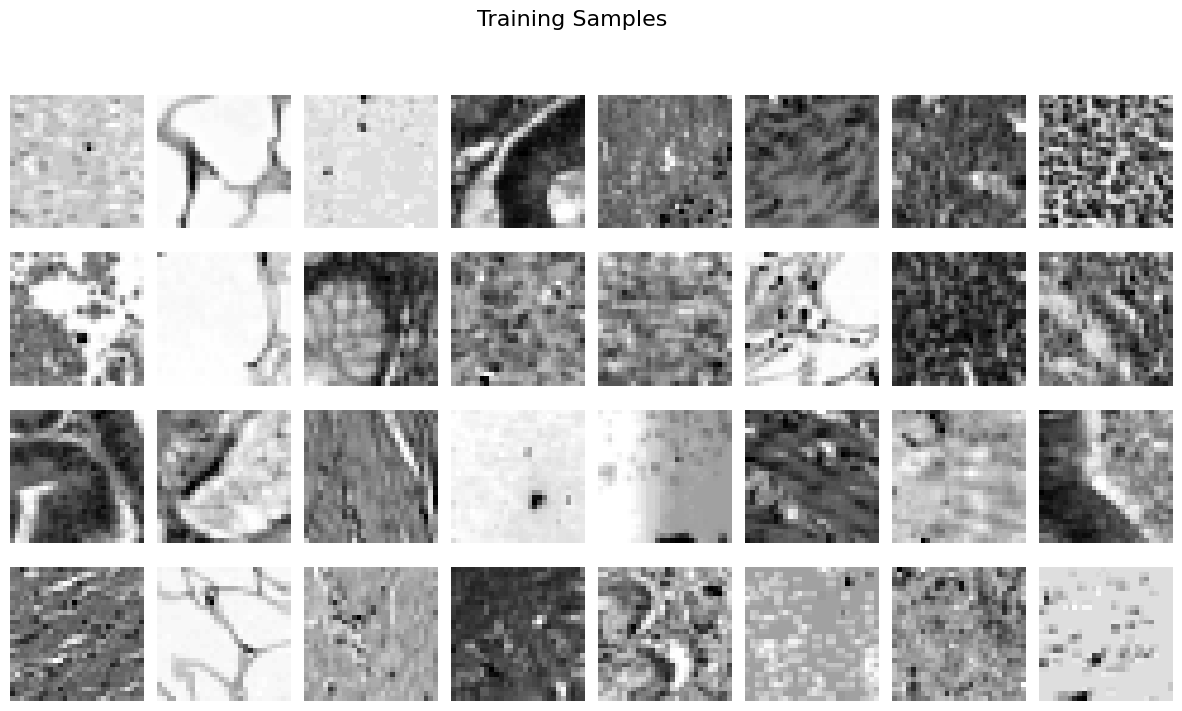

In [10]:
visualize_dataset_samples(train_loader)

In [11]:
# FID calculation functions
def get_inception_features(images, device, batch_size=32):
    # Load Inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    inception_model.fc = nn.Identity()  # Remove classifier layer
    
    # Process images
    if images.shape[1] == 1:  # Convert grayscale to RGB
        images = images.repeat(1, 3, 1, 1)
    
    # Resize to Inception input size
    if images.shape[2] != 299 or images.shape[3] != 299:
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # Scale from [-1, 1] to [0, 1]
    images = (images + 1) / 2.0
    
    features = []
    n_batches = int(np.ceil(images.shape[0] / batch_size))
    
    with torch.no_grad():
        for i in range(n_batches):
            batch = images[i * batch_size:min((i + 1) * batch_size, len(images))].to(device)
            feat = inception_model(batch)
            features.append(feat.cpu().numpy())
    
    return np.concatenate(features, axis=0)

def calculate_fid(real_features, fake_features):
    # Calculate mean and covariance
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)
    
    # Calculate FID
    ssdiff = np.sum((mu_real - mu_fake) ** 2.0)
    covmean = linalg.sqrtm(sigma_real.dot(sigma_fake))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid

def calculate_inception_score(features, splits=10):
    probs = F.softmax(torch.from_numpy(features), dim=1).numpy()
    scores = []
    
    for i in range(splits):
        part = probs[i * (len(probs) // splits):(i + 1) * (len(probs) // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    
    return np.mean(scores), np.std(scores)

# Function for evaluating the model
def evaluate_gan(netG, test_loader, device, num_samples=1000, calc_fid=True):
    print("Evaluating GAN...")
    netG.eval()
    
    # Collect real samples
    real_images = []
    for batch in test_loader:
        images = batch['image'] if isinstance(batch, dict) else batch[0]
        real_images.append(images)
        if len(torch.cat(real_images)) >= num_samples:
            break
    
    real_images = torch.cat(real_images)[:num_samples]
    
    # Generate fake samples
    fake_images = []
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_size_i = min(batch_size, num_samples - i)
            noise = torch.randn(batch_size_i, nz, device=device)
            fake = netG(noise).cpu()
            fake_images.append(fake)
    
    fake_images = torch.cat(fake_images)
    
    # Calculate metrics
    metrics = {}
    
    if calc_fid:
        print("Calculating FID score...")
        real_features = get_inception_features(real_images, device)
        fake_features = get_inception_features(fake_images, device)
        
        fid_score = calculate_fid(real_features, fake_features)
        metrics["fid_score"] = float(fid_score)
        print(f"FID Score: {fid_score:.4f}")
        
        # Calculate Inception Score
        print("Calculating Inception Score...")
        is_mean, is_std = calculate_inception_score(fake_features)
        metrics["inception_score_mean"] = float(is_mean)
        metrics["inception_score_std"] = float(is_std)
        print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    
    # Visualize generated samples
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        if i < 32:
            img = fake_images[i].permute(1, 2, 0).squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    
    plt.suptitle("Generated Samples", fontsize=16)
    plt.savefig(f"evaluation/{data_flag}_wgan_gen_samples.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
    return metrics

# Function to initialize model weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Function to save generated samples
def save_samples(epoch, netG, fixed_noise, writer=None):
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    
    # Save images
    grid = vutils.make_grid(fake, padding=2, normalize=True)
    vutils.save_image(grid, f"generated_images/{data_flag}_wgan_epoch_{epoch}.png")
    
    # Add to TensorBoard if writer is provided
    if writer is not None:
        writer.add_image('Generated Images', grid, epoch)

# Function to clip critic parameters for WGAN
def clip_weights(model, clip_value):
    for p in model.parameters():
        p.data.clamp_(-clip_value, clip_value)


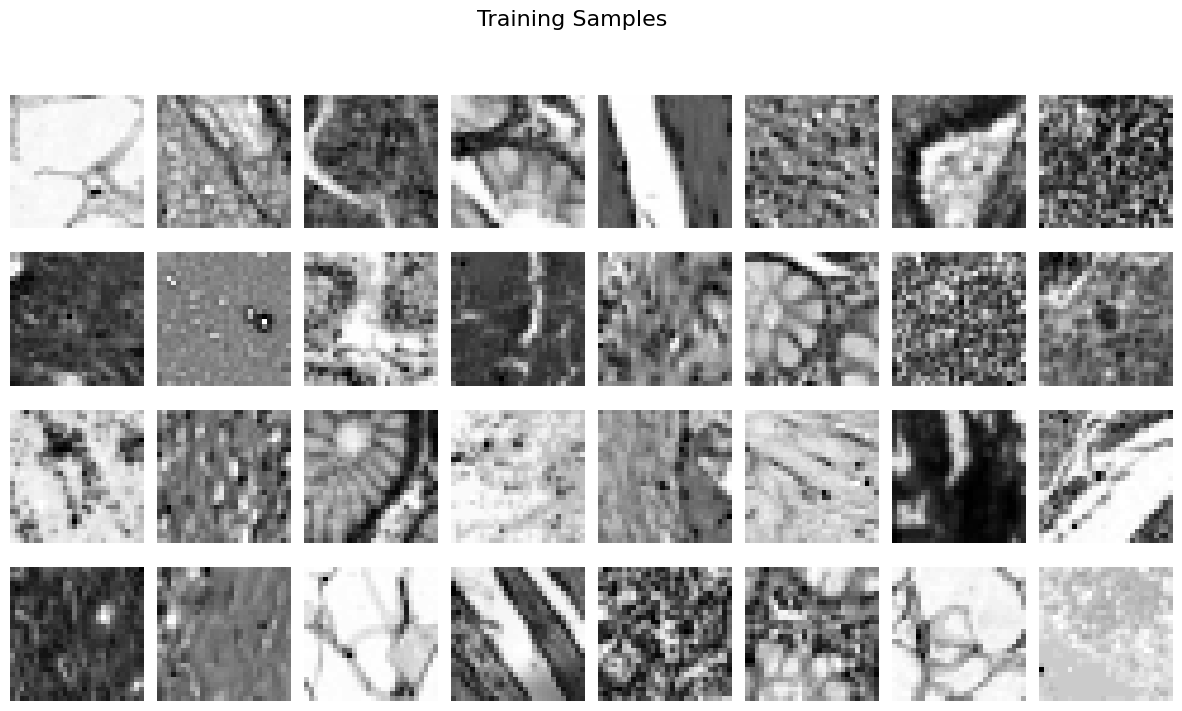

Starting WGAN training...
Starting training...


Epoch 1/50:   0%|          | 0/704 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
Epoch 50/50: 100%|██████████| 704/704 [01:17<00:00,  9.07it/s, G_loss=-0.0242, D_loss=-0.013]   

Evaluating GAN...


Calculating FID score...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 213MB/s] 


FID Score: 67.4243
Calculating Inception Score...
Inception Score: 1.0689 ± 0.0058


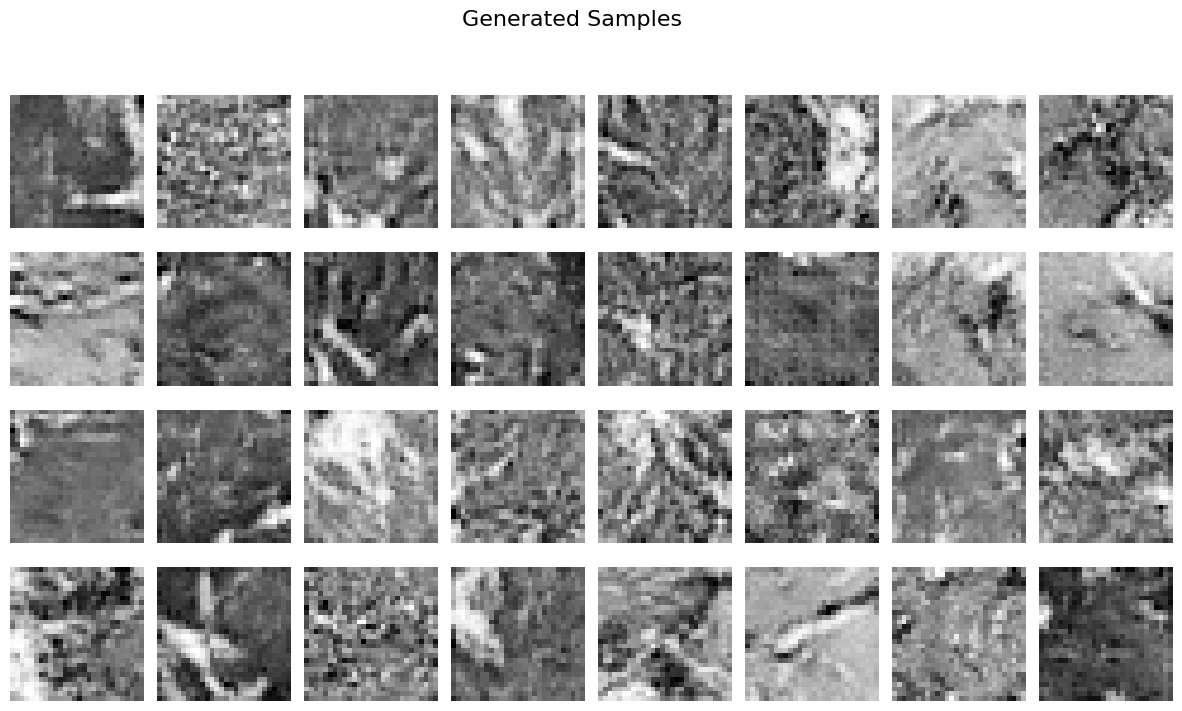

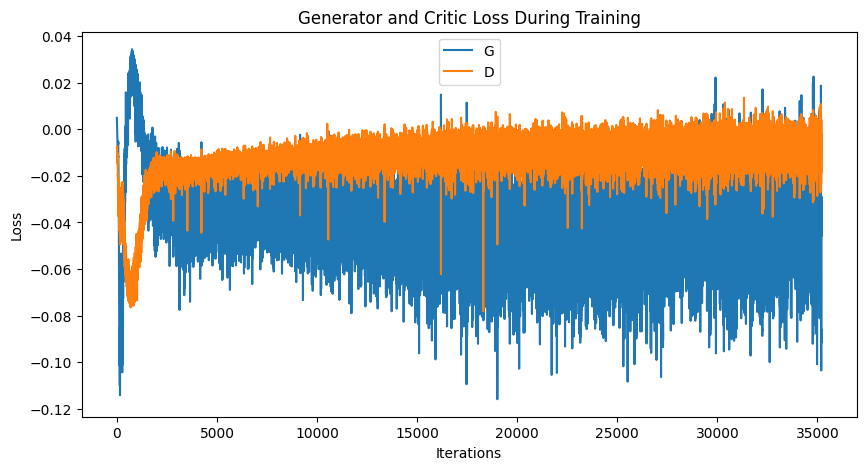

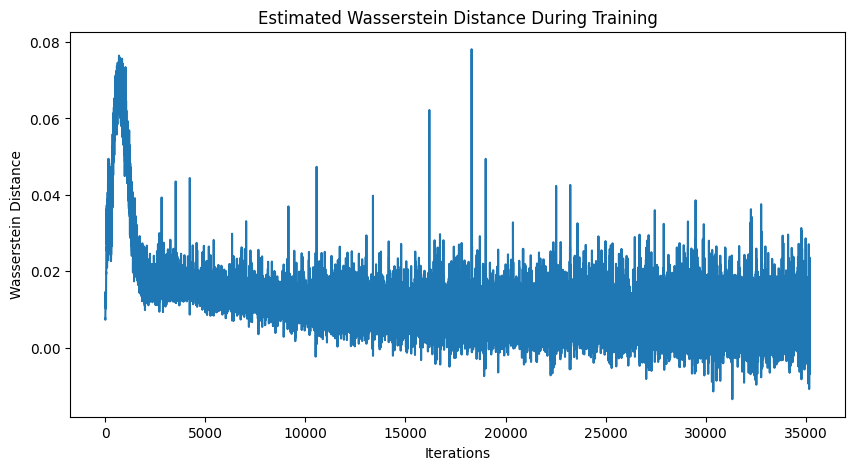

Training complete!


In [12]:
# Main training function
def train_wgan():
    print("Starting WGAN training...")
    
    # Create log directory for TensorBoard
    os.makedirs("logs", exist_ok=True)
    writer = SummaryWriter(f"logs/{data_flag}_wgan")
    
    # Initialize generator and critic
    netG = Generator().to(device)
    netD = Critic().to(device)  # Discriminator is called Critic in WGAN
    
    # Apply weight initialization
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    # Multi-GPU support
    if num_gpus > 1:
        netG = nn.DataParallel(netG)
        netD = nn.DataParallel(netD)
    
    # Optimizers - WGAN typically uses RMSprop instead of Adam
    optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
    optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
    
    # Fixed noise for visualization
    fixed_noise = torch.randn(64, nz, device=device)
    
    # Training loop
    print("Starting training...")
    
    # Monitoring variables
    G_losses = []
    D_losses = []
    iters = 0
    gen_iterations = 0
    
    # For each epoch
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            ############################
            # (1) Update D network (Critic)
            ###########################
            # Train the critic more than the generator
            for _ in range(n_critic):
                # Zero gradients for critic
                netD.zero_grad()
                
                # Format input batch
                real_cpu = batch['image'].to(device) if isinstance(batch, dict) else batch[0].to(device)
                b_size = real_cpu.size(0)
                
                # Forward pass real batch through D
                output_real = netD(real_cpu)
                
                # Generate fake images
                noise = torch.randn(b_size, nz, device=device)
                fake = netG(noise)
                
                # Classify fake batch with D
                output_fake = netD(fake.detach())
                
                # Calculate Wasserstein loss for critic
                # WGAN loss = E[D(x)] - E[D(G(z))]
                # We want to maximize this, so we negate it for gradient descent
                errD = -(torch.mean(output_real) - torch.mean(output_fake))
                
                # Backpropagation
                errD.backward()
                
                # Update critic
                optimizerD.step()
                
                # Clip weights of critic after optimizer step (WGAN requirement)
                clip_weights(netD, weight_clip)
            
            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            
            # Generate fake images
            noise = torch.randn(b_size, nz, device=device)
            fake = netG(noise)
            
            # Forward pass fake batch through D
            output = netD(fake)
            
            # Calculate G's loss based on this output
            # For WGAN, we want to maximize E[D(G(z))], which is equivalent to minimizing -E[D(G(z))]
            errG = -torch.mean(output)
            
            # Backpropagation
            errG.backward()
            
            # Update G
            optimizerG.step()
            
            gen_iterations += 1
            
            # Save losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            # Output training stats
            if iters % 50 == 0:
                progress_bar.set_postfix({
                    'G_loss': errG.item(),
                    'D_loss': errD.item()
                })
                
                # Log to TensorBoard
                writer.add_scalar('Loss/Generator', errG.item(), iters)
                writer.add_scalar('Loss/Critic', errD.item(), iters)
                writer.add_scalar('Wasserstein_Distance', -errD.item(), iters)
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (iters == len(train_loader)-1)):
                save_samples(epoch, netG, fixed_noise, writer)
            
            iters += 1
        
        # Save model checkpoints after each epoch
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': netG.state_dict(),
                'critic_state_dict': netD.state_dict(),
                'optimizer_g_state_dict': optimizerG.state_dict(),
                'optimizer_d_state_dict': optimizerD.state_dict(),
                'g_loss': errG.item(),
                'd_loss': errD.item(),
            }, f"checkpoints/{data_flag}_wgan_epoch_{epoch+1}.pt")
    
    # Final evaluation
    metrics = evaluate_gan(netG, test_loader, device)
    
    # Save metrics
    import json
    with open(f"evaluation/{data_flag}_wgan_metrics.json", "w") as f:
        json.dump(metrics, f)
    
    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Critic Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"evaluation/{data_flag}_wgan_loss.png")
    plt.show()
    
    # Plot Wasserstein distance (negative of critic loss)
    plt.figure(figsize=(10, 5))
    plt.title("Estimated Wasserstein Distance During Training")
    plt.plot([-d for d in D_losses])
    plt.xlabel("Iterations")
    plt.ylabel("Wasserstein Distance")
    plt.savefig(f"evaluation/{data_flag}_wgan_distance.png")
    plt.show()
    
    print("Training complete!")
    return netG, netD

# Run the training
if __name__ == "__main__":
    # Visualize dataset samples first
    visualize_dataset_samples(train_loader)
    
    # Train the WGAN
    netG, netD = train_wgan()
